In [133]:
from matplotlib.pyplot import hist, show
from collections import Counter
import urllib
import codecs
from nltk.stem import WordNetLemmatizer
import numpy as np 
from nltk import Text
import pandas as pd

#downloading the webpage
import requests
import datetime

#parsing a page
from bs4 import BeautifulSoup
import re
#presentation handling
from pptx import Presentation

#file handling
from os import listdir

#WordCloud
from wordcloud import WordCloud
import matplotlib.pyplot as plt

#Translator
from googletrans import Translator

from nltk.probability import FreqDist

## Zestaw czytań do pracy magisterskiej

Przykład

|Data| Dzień tygodnia | Pierwsze czytanie | Psalm | Drugie czytanie | Werset przed Ewangelią | Ewangelia | 
|---|---|---|---|---|---|---|
|21-01-2019|Niedziela| Przez wzgląd na Syjon nie umilknę, przez wzgląd na Jerozolimę nie spocznę, dopóki jej sprawiedliwość nie błyśnie jak zorza i zbawienie jej nie zapłonie jak pochodnia. Wówczas narody ujrzą twą sprawiedliwość i chwałę twoją wszyscy królowie. I nazwą cię nowym imieniem, które usta Pana określą. Będziesz prześliczną koroną w rękach Pana, królewskim diademem w dłoni twego Boga. Nie będą więcej mówić o tobie "Porzucona", o krainie twej już nie powiedzą "Spustoszona". Raczej cię nazwą "Moje w niej upodobanie", a krainę twoją – "Poślubiona". Albowiem spodobałaś się Panu i twoja kraina otrzyma męża. Bo jak młodzieniec poślubia dziewicę, tak twój Budowniczy ciebie poślubi, i jak oblubieniec weseli się z oblubienicy, tak Bóg twój tobą się rozraduje.|---| Bracia: Różne są dary łaski, lecz ten sam Duch; różne też są rodzaje posługiwania, ale jeden Pan; różne są wreszcie działania, lecz ten sam Bóg, sprawca wszystkiego we wszystkich. Wszystkim zaś objawia się Duch dla wspólnego dobra. Jednemu dany jest przez Ducha dar mądrości słowa, drugiemu umiejętność poznawania według tego samego Ducha, innemu jeszcze dar wiary w tymże Duchu, innemu łaska uzdrawiania przez tego samego Ducha, innemu dar czynienia cudów, innemu proroctwo, innemu rozpoznawanie duchów, innemu dar języków i wreszcie innemu łaska tłumaczenia języków. Wszystko zaś sprawia jeden i ten sam Duch, udzielając każdemu tak, jak chce.|Żywe jest słowo Boże i skuteczne, zdolne osądzić pragnienia i myśli serca.|W Kanie Galilejskiej odbywało się wesele i była tam Matka Jezusa. Zaproszono na to wesele także Jezusa i Jego uczniów. A kiedy zabrakło wina, Matka Jezusa rzekła do Niego: "Nie mają wina". Jezus Jej odpowiedział: "Czyż to moja lub Twoja sprawa, Niewiasto? Czy jeszcze nie nadeszła godzina moja?" Wtedy Matka Jego powiedziała do sług: "Zróbcie wszystko, cokolwiek wam powie". Stało zaś tam sześć stągwi kamiennych przeznaczonych do żydowskich oczyszczeń, z których każda mogła pomieścić dwie lub trzy miary. Jezus rzekł do sług: "Napełnijcie stągwie wodą". I napełnili je aż po brzegi. Potem powiedział do nich: "Zaczerpnijcie teraz i zanieście staroście weselnemu". Ci więc zanieśli. Gdy zaś starosta weselny skosztował wody, która stała się winem – a nie wiedział, skąd ono pochodzi, ale słudzy, którzy czerpali wodę, wiedzieli – przywołał pana młodego i powiedział do niego: "Każdy człowiek stawia najpierw dobre wino, a gdy się napiją, wówczas gorsze. Ty zachowałeś dobre wino aż do tej pory". Taki to początek znaków uczynił Jezus w Kanie Galilejskiej. Objawił swoją chwałę i uwierzyli w Niego Jego uczniowie.|

## Zestaw pieśni do pracy magisterskiej

Przykład, wersja jako całość tekstu (bez podziału na refren i zwrotki)

|Id_piosenki | Tytuł|Tekst|
|---|---|---|
|1|Błogosław Duszo moja Pana| ... |


#### Inicjalizacja pd.DataFrame dla piosenek

In [46]:
df_p = pd.DataFrame(data=None, index=None, #pd.date_range('1/1/2019', periods=10, freq='D'), 
                  columns = ["Tytuł","Tekst"])
df_p.head()

,Tytuł,Tekst


In [48]:
def parse_presentation(presentation_path):
    prs = Presentation(presentation_path)
    text = str()
    for slide in prs.slides:
        for shape in slide.shapes:
            if not shape.has_text_frame:
                continue
            for paragraph in shape.text_frame.paragraphs:
                for run in paragraph.runs:
                    text = text + run.text + ' '
    return text

In [67]:
i=0
for file in listdir('prezentacje'):
    path = 'prezentacje/' + file
    song_name = file[:-5]
    text = parse_presentation(path)
    df_p.loc[i] = [song_name, text]
    i=i+1

In [69]:
i

187

In [49]:
path = 'prezentacje/Abba Ojcze.pptx'
parse_presentation(path)

'Ty wyzwoliłeś nas Panie  z kajdan i samych siebie,  a Chrystus stając się bratem  nauczył nas wołać do Ciebie:  Abba Ojcze! Abba Ojcze! Abba Ojcze! 2. Bo Kościół jak drzewo życia w wieczności zapuszcza korzenie, przenika naszą codzienność i pokazuje nam Ciebie. Abba Ojcze! Abba Ojcze! Abba Ojcze! 3. Bóg hojnym Dawcą jest życia, on wyswobodził nas z śmierci i przygarniając do siebie uczynił swoimi dziećmi. Abba Ojcze! Abba Ojcze! Abba Ojcze! 4. Wszyscy jesteśmy braćmi, jesteśmy jedną rodziną. Tej prawdy nic już nie zaćmi i teraz jest jej godzina. Abba Ojcze! Abba Ojcze! Abba Ojcze! '

In [79]:
df_p.head()

,Tytuł,Tekst
0,Abba Ojcze,Ty wyzwoliłeś nas Panie z kajdan i samych sie...
1,Alleluja (Niech zabrzmi Panu),"Ref. Alleluja, Alleluja, Alleluja, Alleluja. ..."
2,"Alleluja, Alleluja, Amen Amen, Alleluja","Ref. Alleluja, Alleluja, Amen, Amen, Alleluja..."
3,"Blisko, blisko, blisko jesteś","1. Blisko, blisko, blisko Jesteś Panie mój Bli..."
4,Bo góry mogą ustąpić,1. Bo góry mogą ustąpić i pagórki się zachwiać...


#### Inicjalizacja pd.DataFrame dla czytań

In [80]:
df = pd.DataFrame(data=None, index=None, #pd.date_range('1/1/2019', periods=10, freq='D'), 
                  columns = ["Dzień tygodnia","Pierwsze czytanie", "Psalm", "Drugie czytanie", 
                                                    "Werset przed Ewangelią", "Ewangelia"])
df.head()

,Dzień tygodnia,Pierwsze czytanie,Psalm,Drugie czytanie,Werset przed Ewangelią,Ewangelia


In [81]:
numdays = 10
base = datetime.date.today()
date_list = [base - datetime.timedelta(days=x) for x in range(0, numdays)]
dates_cleaned = [str(x).replace('-','') for x in date_list]
dates_names = [x.strftime("%A") for x in date_list]

## Czytania danego dnia

In [82]:
#czytanie na dziś
now = datetime.datetime.now()
today = datetime.date.today()
year = str(now.year)
month = str(now.month)
if len(month) == 1:
    month = "0" + month

day = str(now.day)
if len(day) == 1:
    day = "0" + day

ymd = year+month+day
today_name = now.strftime("%A")
day_name = today_name
#day_name = 'Sunday'

address = "http://mateusz.pl/czytania/" + year + "/" + ymd + ".html"
#address = "http://mateusz.pl/czytania/2018/20181021.html" #niedziela

#print(address)

In [83]:
def get_adresses(n):
    adresses = []
    date_list = [base - datetime.timedelta(days=x) for x in range(0, n)]
    dates_cleaned = [str(x).replace('-','') for x in date_list]
    for date in dates_cleaned:
        ymd = date
        address = "http://mateusz.pl/czytania/" + ymd[:4]+ "/" + ymd + ".html"
        adresses.append(address)
    return adresses

In [84]:
get_adresses(5)

['http://mateusz.pl/czytania/2019/20190122.html',
 'http://mateusz.pl/czytania/2019/20190121.html',
 'http://mateusz.pl/czytania/2019/20190120.html',
 'http://mateusz.pl/czytania/2019/20190119.html',
 'http://mateusz.pl/czytania/2019/20190118.html']

In [85]:
def get_readings(address, day_name):
    page = requests.get(address)
    soup = BeautifulSoup(page.content, 'html.parser')
    #print(soup.prettify()) 
    #Exception handling for more readings
    try:
        #section = list(soup.children)[9]
        #section_content = section.find_all('p')   
        section = list(soup.children)
        section_content1 = section[2].find_all('p')
        if day_name == 'Sunday':
            section_content2 = section[6]
            section_content3 = section[8]
            section_content4 = section[12]
        else:
            section_content2 = None
            section_content3 = section[4]
            section_content4 = section[8]
            
        pierwsze_czytanie = str(section_content1[6])
        drugie_czytanie = str(section_content2)
        tekst_przed_ewangelia = str(section_content3)
        psalm_ref = str(section_content1[7])
        ewangelia = str(section_content4)
        document = [pierwsze_czytanie, psalm_ref, drugie_czytanie, tekst_przed_ewangelia, ewangelia]
        return document
    except:
        pass
        section = soup.find_all('section')[0]
        section_content =section.find_all('p')

In [86]:
df.head()

,Dzień tygodnia,Pierwsze czytanie,Psalm,Drugie czytanie,Werset przed Ewangelią,Ewangelia


In [87]:
document = get_readings(address, today)
pierwsze_czytanie = document[0]
psalm_ref = document[1]
drugie_czytanie = document[2]
tekst_przed_ewangelia = document[3]
ewangelia = document[4]

In [88]:
pierwsze_czytanie

'<p>\r\n                        (Hbr 6, 10-20) <br/>\r\n                        Bracia: Nie jest Bóg niesprawiedliwy, aby zapomniał o czynie waszym i miłości, którą okazaliście dla imienia Jego, gdy usługiwaliście świętym i jeszcze usługujecie. Pragniemy zaś, by każdy z was okazywał tę samą gorliwość w doskonaleniu nadziei aż do końca, abyście nie stali się ospałymi, ale naśladowali tych, którzy przez wiarę i cierpliwość stają się dziedzicami obietnic. Albowiem gdy Bóg Abrahamowi uczynił obietnicę, nie mając nikogo większego, na kogo mógłby przysiąc, poprzysiągł na samego siebie, mówiąc: "Zaiste, hojnie cię pobłogosławię i ponad miarę rozmnożę". A ponieważ Abraham tak cierpliwie oczekiwał, otrzymał to, co było obiecane. Ludzie przysięgają na kogoś wyższego, a przysięga dla stwierdzenia prawdy jest zakończeniem każdego sporu między nimi. Dlatego Bóg, pragnąc okazać dziedzicom obietnicy ponad wszelką miarę niezmienność swego postanowienia, wzmocnił je przysięgą, abyśmy przez dwie rzeczy 

In [89]:
drugie_czytanie

'None'

In [90]:
psalm_ref

'<p>\r\n                        (Ps 111 (110), 1b-2. 4-5. 9 i 10c) <br/>\n<small>REFREN:</small> Pan Bóg pamięta o swoim przymierzu</p>'

In [91]:
tekst_przed_ewangelia

'<p>\r\n                            Aklamacja (Ef 1, 17-18 <br>\r\n                        Niech Ojciec Pana naszego, Jezusa Chrystusa, przeniknie nasze serca swoim światłem, abyśmy wiedzieli, czym jest nadzieja naszego powołania.\r\n                    </br></p>'

In [92]:
ewangelia

'<p>\r\n                        (Mk 2, 23-28) <br>\r\n                        Pewnego razu, gdy Jezus przechodził w szabat pośród zbóż, uczniowie Jego zaczęli po drodze zrywać kłosy. Na to faryzeusze mówili do Niego: "Patrz, czemu oni czynią w szabat to, czego nie wolno?" On im odpowiedział: "Czy nigdy nie czytaliście, co uczynił Dawid, kiedy znalazł się w potrzebie i poczuł głód, on i jego towarzysze? Jak wszedł do domu Bożego za Abiatara, najwyższego kapłana, i jadł chleby pokładne, które tylko kapłanom jeść wolno; i dał również swoim towarzyszom". I dodał: "To szabat został ustanowiony dla człowieka, a nie człowiek dla szabatu. Zatem Syn Człowieczy jest Panem także szabatu".\r\n                    </br></p>'

## Noise removal // Cleaning

In [93]:
#first phase
def clean_html(raw):
    cleaner = re.compile('<.*?>')
    cleantext = re.sub(cleaner, '', raw)
    return cleantext

def clean_proverbs (raw):
    cleaner = re.compile('\([^)]*\)')
    cleantext = re.sub(cleaner, '',raw)
    return cleantext

def clean_indent(raw):
    cleaner = re.compile('^\s+')
    cleantext = re.sub(cleaner, '',raw)
    return cleantext

def clean_text(raw):
    text = clean_html(raw)
    text = clean_proverbs(text)
    text = clean_indent(text)
    return text

In [94]:
n=5
date_list = [base - datetime.timedelta(days=x) for x in range(0, n)]
dates_cleaned = [str(x).replace('-','') for x in date_list]
dates_names = [x.strftime("%A") for x in date_list]
adresses = get_adresses(n)
documents = []
for i in range(len(adresses)):
    doc = get_readings(adresses[i], dates_names[i])
    doc_cleaned = [clean_text(str(text)) for text in doc]
    input_row = [dates_names[i]]
    for each in doc_cleaned:
        input_row.append(each)
    df.loc[date_list[i]] = input_row
        


In [95]:
df.head()

,Dzień tygodnia,Pierwsze czytanie,Psalm,Drugie czytanie,Werset przed Ewangelią,Ewangelia
2019-01-22,Tuesday,"Bracia: Nie jest Bóg niesprawiedliwy, aby zapo...",", 1b-2. 4-5. 9 i 10c) \nREFREN: Pan Bóg pamięt...",None,"Aklamacja (Ef 1, 17-18 \r\n ...","Pewnego razu, gdy Jezus przechodził w szabat p..."
2019-01-21,Monday,"Każdy arcykapłan, spomiędzy ludzi brany, dla l...",", 1b-2. 3-4) \nREFREN: Jesteś kapłanem, tak ja...",None,Aklamacja \r\n Żywe je...,Uczniowie Jana i faryzeusze mieli właśnie post...
2019-01-20,Sunday,"Przez wzgląd na Syjon nie umilknę, przez wzglą...",", 1-2a. 2b-3. 7-8. 9 i 10ac) \nREFREN: Pośród ...","Bracia: Różne są dary łaski, lecz ten sam Duch...",Aklamacja \r\n Bóg wez...,W Kanie Galilejskiej odbywało się wesele i był...
2019-01-19,Saturday,"Bracia: Żywe jest słowo Boże, skuteczne i ostr...",", 8-9. 10 i 15) \nREFREN: Słowa Twe, Panie, są...",None,Aklamacja \r\n Pan pos...,Jezus wyszedł znowu nad jezioro. Cały lud przy...
2019-01-18,Friday,"Bracia: Lękajmy się, gdy jeszcze trwa obietnic...",", 3 i 4bc. 6-7. 8) \nREFREN: Wielkich dzieł Bo...",None,Aklamacja \r\n Wielki ...,Gdy po pewnym czasie Jezus wrócił do Kafarnaum...


In [96]:
df.index[1]

datetime.date(2019, 1, 21)

In [142]:
text = df.loc[datetime.date(2019, 1, 20),'Ewangelia']
text

'W Kanie Galilejskiej odbywało się wesele i była tam Matka Jezusa. Zaproszono na to wesele także Jezusa i Jego uczniów. A kiedy zabrakło wina, Matka Jezusa rzekła do Niego: "Nie mają wina". Jezus Jej odpowiedział: "Czyż to moja lub Twoja sprawa, Niewiasto? Czy jeszcze nie nadeszła godzina moja?" Wtedy Matka Jego powiedziała do sług: "Zróbcie wszystko, cokolwiek wam powie". Stało zaś tam sześć stągwi kamiennych przeznaczonych do żydowskich oczyszczeń, z których każda mogła pomieścić dwie lub trzy miary. Jezus rzekł do sług: "Napełnijcie stągwie wodą". I napełnili je aż po brzegi. Potem powiedział do nich: "Zaczerpnijcie teraz i zanieście staroście weselnemu". Ci więc zanieśli. Gdy zaś starosta weselny skosztował wody, która stała się winem – a nie wiedział, skąd ono pochodzi, ale słudzy, którzy czerpali wodę, wiedzieli – przywołał pana młodego i powiedział do niego: "Każdy człowiek stawia najpierw dobre wino, a gdy się napiją, wówczas gorsze. Ty zachowałeś dobre wino aż do tej pory". Ta

### Tłumaczenie

In [143]:
translator = Translator()
t = translator.translate(text)

In [144]:
t.text

'There was a wedding party in Cana Galilee, and the Mother of Jesus was there. The wedding party was also invited to Jesus and His disciples. And when the wine ran out, the mother of Jesus said to him, "They have no wine." Jesus said to her, "Is it my or your cause, woman? Has not my hour yet come?" Then His Mother said to the servants: "Do whatever he tells you." There were six stone waterpots for Jewish purifications, each of which could hold two or three measures. Jesus said to the servants, "Fill the jars with water." And they filled them to the brim. Then he said to them, "Draw now and take it to the wedding gentleman." So they carried it. When the wedding star tried the water which became the wine - and he did not know where it came from, but the servants who drew water, they knew - called the bridegroom and said to him: "Every man puts a good wine first and when they drink, then worse, you have kept good wine until now. " This is the beginning of the signs Jesus made in Cana of 

## Tokenization & Segmentation

In [145]:
from nltk.tokenize import word_tokenize, sent_tokenize

In [151]:
sentences = sent_tokenize(text)
sentences[:5]

['W Kanie Galilejskiej odbywało się wesele i była tam Matka Jezusa.',
 'Zaproszono na to wesele także Jezusa i Jego uczniów.',
 'A kiedy zabrakło wina, Matka Jezusa rzekła do Niego: "Nie mają wina".',
 'Jezus Jej odpowiedział: "Czyż to moja lub Twoja sprawa, Niewiasto?',
 'Czy jeszcze nie nadeszła godzina moja?"']

In [150]:
tokens = word_tokenize(text)
lower_tokens = [t.lower() for t in tokens]
lower_tokens[:5]

['w', 'kanie', 'galilejskiej', 'odbywało', 'się']

## Normalization / Preprocessing

#### Lemmatyzacja (lemmatisation) 
Algorytm znajdowania lemmy, formy podstawowej wyrazu w obszarze części mowy którą reprezentuje. Inaczej: wyszukiwanie formy kanonicznej leksemu. W komputerowej analizie języka naturalnego lemmatyzacja jest operacją bardziej precyzyjną niż stemmatyzacja. 

#### Stemmatyzacja (stemming) 
Sprowadzenie wyrazu reprezentującego dowolną część mowy do stemu, rdzenia postaci źródłowej, najczęściej rzeczownika, bądź niekiedy nawet sekwencji znaków nie mającej samodzielnego znaczenia w języku naturalnym. 

In [56]:
from nltk.stem.porter import *

def stem_tokens(tokens, stemmer):
    stemmed = []
    for item in tokens:
        stemmed.append(stemmer.stem(item))
    return stemmed

stemmer = PorterStemmer()
stemmed = stem_tokens(no_stops, stemmer)
count = Counter(stemmed)

In [153]:
# Retain alphabetic words: alpha_only
alpha_only = [t for t in lower_tokens if t.isalpha()]
alpha_only[:5]

['w', 'kanie', 'galilejskiej', 'odbywało', 'się']

In [154]:
#Read polish stopwords file
polish_stops = codecs.open("polishStopWords",'r','utf-8')
ps = polish_stops.read().split('\n')
polish_stops.close()

In [156]:
# Remove all stop words: no_stops
no_stops = [t for t in alpha_only if t not in ps]
no_stops[:5]

['kanie', 'galilejskiej', 'odbywało', 'wesele', 'matka']

### Bag of words

In [157]:
bow = Counter(no_stops)

In [187]:
bow.most_common(10)

[('matka', 3),
 ('jezusa', 3),
 ('jezus', 3),
 ('kanie', 2),
 ('galilejskiej', 2),
 ('wesele', 2),
 ('wina', 2),
 ('sług', 2),
 ('powiedział', 2),
 ('dobre', 2)]

### Word cloud

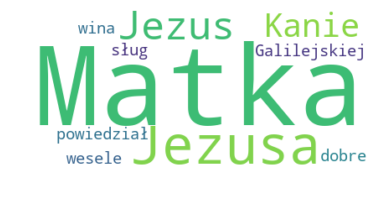

In [160]:
# Create and generate a word cloud image:
wordcloud = WordCloud(stopwords = ps, 
                      max_font_size=150, 
                      max_words=10, 
                      background_color="white").generate(clean_text(text))

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

### Term frequency

In [161]:
fdist = FreqDist(no_stops)

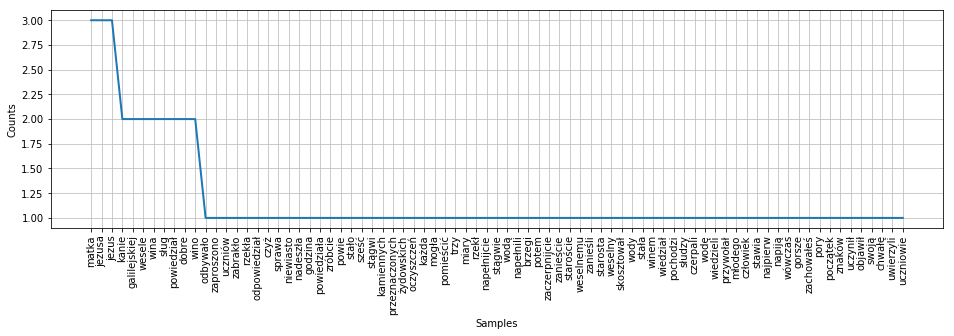

In [163]:
plt.figure(figsize=(16,4))
fdist_plot = fdist.plot()
plt.show()

In [164]:
#occurs only once
fdist.hapaxes()

['odbywało',
 'zaproszono',
 'uczniów',
 'zabrakło',
 'rzekła',
 'odpowiedział',
 'czyż',
 'sprawa',
 'niewiasto',
 'nadeszła',
 'godzina',
 'powiedziała',
 'zróbcie',
 'powie',
 'stało',
 'sześć',
 'stągwi',
 'kamiennych',
 'przeznaczonych',
 'żydowskich',
 'oczyszczeń',
 'każda',
 'mogła',
 'pomieścić',
 'trzy',
 'miary',
 'rzekł',
 'napełnijcie',
 'stągwie',
 'wodą',
 'napełnili',
 'brzegi',
 'potem',
 'zaczerpnijcie',
 'zanieście',
 'staroście',
 'weselnemu',
 'zanieśli',
 'starosta',
 'weselny',
 'skosztował',
 'wody',
 'stała',
 'winem',
 'wiedział',
 'pochodzi',
 'słudzy',
 'czerpali',
 'wodę',
 'wiedzieli',
 'przywołał',
 'młodego',
 'człowiek',
 'stawia',
 'najpierw',
 'napiją',
 'wówczas',
 'gorsze',
 'zachowałeś',
 'pory',
 'początek',
 'znaków',
 'uczynił',
 'objawił',
 'swoją',
 'chwałę',
 'uwierzyli',
 'uczniowie']

In [165]:
x = bow.most_common(5)
keys = []
for each in x:
    #print(each)
    keys.append(each[0])

In [168]:
#to fix
#text.dispersion_plot(keys)

### N-Grams

In [169]:
from sklearn.feature_extraction.text import CountVectorizer

In [170]:
#z linked in
def clean_text2(text):
    text = "".join([word for word in text if word not in string.punctuation])
    tokens = re.split('\W+', text)
    text = [ps.stem(word) for word in tokens if word not in stopwords]
    return text

In [171]:
ngram_vect = CountVectorizer(ngram_range=(2,2))
X_counts = ngram_vect.fit_transform(df['Ewangelia'])

print(X_counts.shape)
print(ngram_vect.get_feature_names())

(5, 579)
['abiatara najwyższego', 'aby powołać', 'ale grzeszników', 'ale słudzy', 'alfeusza siedzącego', 'aż do', 'aż po', 'bluźni któż', 'boga jezus', 'boga mówiąc', 'bowiem było', 'bożego za', 'brzegi potem', 'bukłaki przepadną', 'bukłaki wino', 'bukłaków przeciwnym', 'była tam', 'było miejsca', 'było tych', 'będą pościć', 'cały lud', 'celnej rzekł', 'celnikami grzesznikami', 'celnikami mówili', 'celników grzeszników', 'chleby pokładne', 'chodź otóż', 'chwałę uwierzyli', 'ci którzy', 'ci więc', 'ci wstań', 'co uczynił', 'cokolwiek wam', 'czas kiedy', 'czasie jezus', 'czego nie', 'czegoś podobnego', 'czemu myśli', 'czemu on', 'czemu oni', 'czerpali wodę', 'czterech nie', 'czy goście', 'czy jeszcze', 'czy nigdy', 'czy też', 'czynią szabat', 'czytaliście co', 'czyż to', 'część ze', 'człowieczy jest', 'człowieczy ma', 'człowiek dla', 'człowiek stawia', 'człowieka nie', 'cóż jest', 'dach nad', 'dawid kiedy', 'dał również', 'dla człowieka', 'dla szabatu', 'dlaczego uczniowie', 'do domu', '

In [172]:
ngram_vect_p = CountVectorizer(ngram_range=(2,2))
X_counts_p = ngram_vect_p.fit_transform(df_p['Tekst'])

print(X_counts_p.shape)
print(ngram_vect_p.get_feature_names())

(187, 6883)
['abba ojcze', 'abrahama izaaka', 'abrahama pomny', 'abrahama ref', 'abrahamowi jego', 'aby każdy', 'aby nami', 'aby nas', 'aby niewinnie', 'aby twój', 'aby wysłuchać', 'aby żyć', 'abym gasił', 'abym mógł', 'abym nie', 'abym przejrzał', 'abym przemówił', 'abym stał', 'abyś mógł', 'abyś nowe', 'abyśmy też', 'adonai nadejdzie', 'adonai odkąd', 'adonai wszyscy', 'albowiem dobry', 'albowiem tylko', 'albowiem uczynił', 'ale miłość', 'ale wiem', 'ale życie', 'alleluja abyśmy', 'alleluja alleluja', 'alleluja amen', 'alleluja chwała', 'alleluja jezus', 'alleluja niech', 'alleluja on', 'alleluja pan', 'alleluja panu', 'alleluja pokłońmy', 'alleluja posyła', 'alleluja radujmy', 'alleluja ref', 'alleluja słońce', 'alleluja ujrzały', 'alleluja wielbimy', 'alleluja śpiewajcie', 'amen alleluja', 'amen amen', 'amen będziemy', 'amen ref', 'amor ubi', 'ani bajką', 'ani jednej', 'aniołami tak', 'aniołami wielbią', 'aniołowie błogosławcie', 'anioły wywyższona', 'aniołów tobie', 'aniołów śpiew

### Tf-idf 

#### Term frequency - inverse document frequency
Ważenie częstością termów - odwrotna częstość w dokumentach - jedna z metod obliczania wagi słów w oparciu o liczbę ich wystąpień, należąca do grupy algorytmów obliczających statystyczne wagi termów. 
- Każdy dokument reprezentowany jest przez wektor, składający się z wag słów występujących w tym dokumencie. 
- TFIDF informuje o częstości wystąpienia termów uwzględniając jednocześnie odpowiednie wyważenie znaczenia lokalnego termu i jego znaczenia w kontekście pełnej kolekcji dokumentów. 

https://pl.wikipedia.org/wiki/TFIDF

- Pozwala na określenie rzadkich, ale ważnych słów każdym dokumencie

$$w(i,j) = tf(i,j) * log(\frac{N}{df(i)})$$

gdzie:

>* w(i,f) - waga tokenu i w dokumencie j
>* tf(i,j) - liczba wystąpień tokenu i w dokumencie j
>* df(i) - licza dokumentów zawierających token i
>*N - liczba wszystkich dokumentów

In [179]:
def clean_text3(text):
    text = "".join([word for word in text if word not in string.punctuation])
    tokens = re.split('\W+', text)
    #text = [ps.stem(word) for word in tokens if word not in stopwords]
    return tokens

In [180]:
#from gensim.models.tfidfmodel import TfidfModel
#from nltk.corpus import wordnet as wn
import string
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vect = TfidfVectorizer(analyzer=clean_text3)
X_tfidf = tfidf_vect.fit_transform(df['Ewangelia'])
print(X_tfidf.shape)
print(tfidf_vect.get_feature_names())

(5, 413)
['', 'A', 'Abiatara', 'Alfeusza', 'Boga', 'Bożego', 'Cały', 'Ci', 'Czemu', 'Czy', 'Czyż', 'Człowieczy', 'Cóż', 'Dawid', 'Dlaczego', 'Dziecko', 'Galilejskiej', 'Gdy', 'I', 'Jak', 'Jana', 'Jego', 'Jej', 'Jezus', 'Jezusa', 'Jezusem', 'Kafarnaum', 'Kanie', 'Każdy', 'Któż', 'Lecz', 'Lewiego', 'Matka', 'Mną', 'Mówię', 'Na', 'Napełnijcie', 'Nie', 'Niego', 'Niektórzy', 'Niewiasto', 'Nigdy', 'Nikt', 'Nim', 'Objawił', 'Odpuszczone', 'On', 'Otóż', 'Panem', 'Patrz', 'Pewnego', 'Piśmie', 'Potem', 'Przyszli', 'Pójdź', 'Raczej', 'Stało', 'Syn', 'Taki', 'Ten', 'To', 'Twoi', 'Twoja', 'Ty', 'Uczniowie', 'W', 'Wielu', 'Wino', 'Wstań', 'Wtedy', 'Zaczerpnijcie', 'Zaproszono', 'Zatem', 'Zdumieli', 'Zebrało', 'Zróbcie', 'a', 'aby', 'ale', 'aż', 'bluźni', 'bowiem', 'brzegi', 'bukłaki', 'bukłaków', 'była', 'było', 'będą', 'celnej', 'celnikami', 'celników', 'chleby', 'chodź', 'chwałę', 'ci', 'co', 'cokolwiek', 'czas', 'czasie', 'czego', 'czegoś', 'czemu', 'czerpali', 'czterech', 'czy', 'czynią', 'czyta

In [181]:
X_tfidf_df = pd.DataFrame(X_tfidf.toarray())
X_tfidf_df.columns = tfidf_vect.get_feature_names()
X_tfidf_df

,,A,Abiatara,Alfeusza,Boga,Bożego,Cały,Ci,Czemu,Czy,...,został,zrywać,ów,łata,łatwiej,łaty,źle,że,żebyście,żydowskich
0,0.049265,0.000000,0.103387,0.000000,0.000000,0.103387,0.000000,0.00000,0.000000,0.069240,...,0.103387,0.103387,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
1,0.040323,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.056672,...,0.000000,0.000000,0.084622,0.084622,0.000000,0.084622,0.000000,0.000000,0.000000,0.00000
2,0.034671,0.048728,0.000000,0.000000,0.000000,0.000000,0.000000,0.07276,0.000000,0.048728,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.07276
3,0.044890,0.063091,0.000000,0.094206,0.000000,0.000000,0.094206,0.00000,0.076005,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.094206,0.076005,0.000000,0.00000
4,0.031091,0.043698,0.000000,0.000000,0.130498,0.000000,0.000000,0.00000,0.105285,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.065249,0.000000,0.000000,0.157927,0.065249,0.00000


### Statystyki

In [182]:
def lexical_diversity(text):
    return len(text)/len(set(text))

def percentage(count,total):
    return 100 * count/total

In [183]:
lexical_diversity(text)

21.41509433962264

In [192]:
percentage(text.count(bow.most_common(1)[0][0]),len(text))

0.0